In [58]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [59]:
# Read the data from the csv file
ratings = pd.read_csv('clean_data/books_rating_clean.csv')
books = pd.read_csv('clean_data/books_data_clean.csv')

In [60]:
# pick random user
user_id = ratings['user_id'].sample(1).iloc[0]
print(user_id)

A21W6PCDZWG15R


In [61]:
test_user = "A126KX6FVI4T66"
#test_user = "A1K9IG5MP8RW75"

In [88]:
# get n most popular books
n_books= 200
popular_books = ratings['title'].value_counts()[0:n_books].index.tolist()
top_20_books = popular_books[0:20]

# keep only the popular books
popular_books_data = books[books['title'].isin(popular_books)]
popular_books_data = popular_books_data[popular_books_data['description'].notna()]
popular_books_data.reset_index(drop=True, inplace=True)

# get the ratings of the popular books
popular_books_ratings = ratings[ratings['title'].isin(popular_books_data['title'].tolist())]

# reset the index
popular_books_ratings.reset_index(drop=True, inplace=True)

# Recommendations using network-based algorithms

In [89]:
# Build the tfidf matrix with the descriptions
text_content = popular_books_data['description']
vector = TfidfVectorizer(max_df=0.5,         # drop words that occur in more than X percent of documents
                        min_df=0.05,      # only use words that appear at least X times
                        stop_words='english', # remove stop words
                        lowercase=True, # Convert everything to lower case 
                        use_idf=True,   # Use idf
                        norm=u'l2',     # Normalization
                        smooth_idf=True # Prevents divide-by-zero errors
                        )

tfidf = vector.fit_transform(text_content)
terms = vector.get_feature_names_out()


df_tfidfvect = pd.DataFrame(data = tfidf.toarray(),columns = terms)

# Clustering  Kmeans
k = round(n_books/10)
print("number of clusters: ", k)
kmeans = KMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = np.argsort(kmeans.cluster_centers_, axis=1)[:, ::-1]

#print the centers of the clusters
[print([terms[j] for j in centers[i, :15]]) for i in range(k)]

# convert description to vector
request_transform = vector.transform(popular_books_data['description'])

# assign each book to a cluster
cluster_asign = kmeans.predict(request_transform)

# Save the cluster of each book in the dataframe
popular_books_data['cluster'] = kmeans.predict(request_transform) 


number of clusters:  20


c:\Users\Lenovo\OneDrive - Danmarks Tekniske Universitet\9. semester\CompTool\comptool\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


['case', 'killer', 'crime', 'takes', 'series', 'woman', 'murder', 'thriller', 'bestselling', 'life', 'dead', 'little', 'home', 'year', 'child']
['life', 'work', 'way', 'job', 'people', 'old', 'bestseller', 'world', 'dark', 'living', 'make', 'family', 'story', 'just', 'book']
['series', 'world', 'cover', 'epic', 'books', 'soon', 'truth', 'book', 'power', 'like', 'questions', 'best', 'comes', 'begins', 'home']
['edition', 'classic', 'america', 'years', 'reader', 'novel', 'life', 'just', 'king', 'men', 'questions', 'night', 'including', 'characters', 'written']
['father', 'man', 'family', 'time', 'american', 'twentieth', 'century', 'great', 'young', 'girl', 'old', 'comes', 'age', 'lives', 'dangerous']
['van', 'een', 'het', 'little', 'times', 'york', 'new', 'thriller', 'american', 'fiction', 'man', 'greatest', 'great', 'girl', 'life']
['fiction', 'literary', 'life', 'new', 'like', 'classic', 'dark', 'heart', 'world', 'masterpiece', 'including', 'century', 'stories', 'man', 'murder']
['new'

In [90]:
# check that the cluster are balanced
popular_books_data['cluster'].value_counts()

cluster
0     15
7     14
1     12
10    11
2     11
14    11
17    10
16    10
5      9
8      9
4      8
3      8
13     7
11     7
18     6
12     6
6      5
19     5
9      4
15     3
Name: count, dtype: int64

In [91]:
# define a function to find 5 most similar books based on the TD-IDF matrix
def find_similar(tfidf_matrix, index, top_n=5):
    cosine_similarities = cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = sorted(range(len(cosine_similarities)), key=cosine_similarities.__getitem__, reverse=True)
    similar_indices = [i for i in related_docs_indices if i != index][:top_n]
    return similar_indices

In [92]:
# create the graph
G = nx.Graph()

# construct the graph
for i, rowi in popular_books_data.iterrows():
    # add nodes for the book
    G.add_node(rowi['title'], key=rowi['title'], label="BOOK", rating=rowi['avg_rating'])

    # add nodes for the authors and connect them to the book
    if not G.has_node(rowi['authors']):
        G.add_node(rowi['authors'],label="authors")
    
    # add categories and connect them to the book
    if not G.has_node(rowi['cluster']):
        G.add_node(rowi['cluster'],label="cluster")
    
    # add edges between titles, authors and clusters
    G.add_edge(rowi['title'], rowi['authors'])
    G.add_edge(rowi['cluster'], rowi['title'])
    G.add_edge(rowi['cluster'], rowi['authors'])
    
    # find the 5 most similar books and connect them to the book
    indices = find_similar(tfidf, i, top_n = 5)

    # add edges between the book and the 5 most similar books
    for idx in indices:
        G.add_edge(rowi["title"], popular_books_data['title'].loc[idx], label="SIMILARITY")

In [93]:
# base node size on avg_rating attribute
sizes = []

# generate a list of colors for the nodes
colors = []
label_vec = {}
for node in G:
    if G.nodes[node]['label'] == "BOOK":
        sizes.append(10*G.nodes[node]['rating'])
        colors.append('red')
        if node in top_20_books:
            label_vec[node] = node
    elif G.nodes[node]['label'] == "authors":
        sizes.append(10)
        colors.append('green')
    else:
        sizes.append(10)
        colors.append('blue')

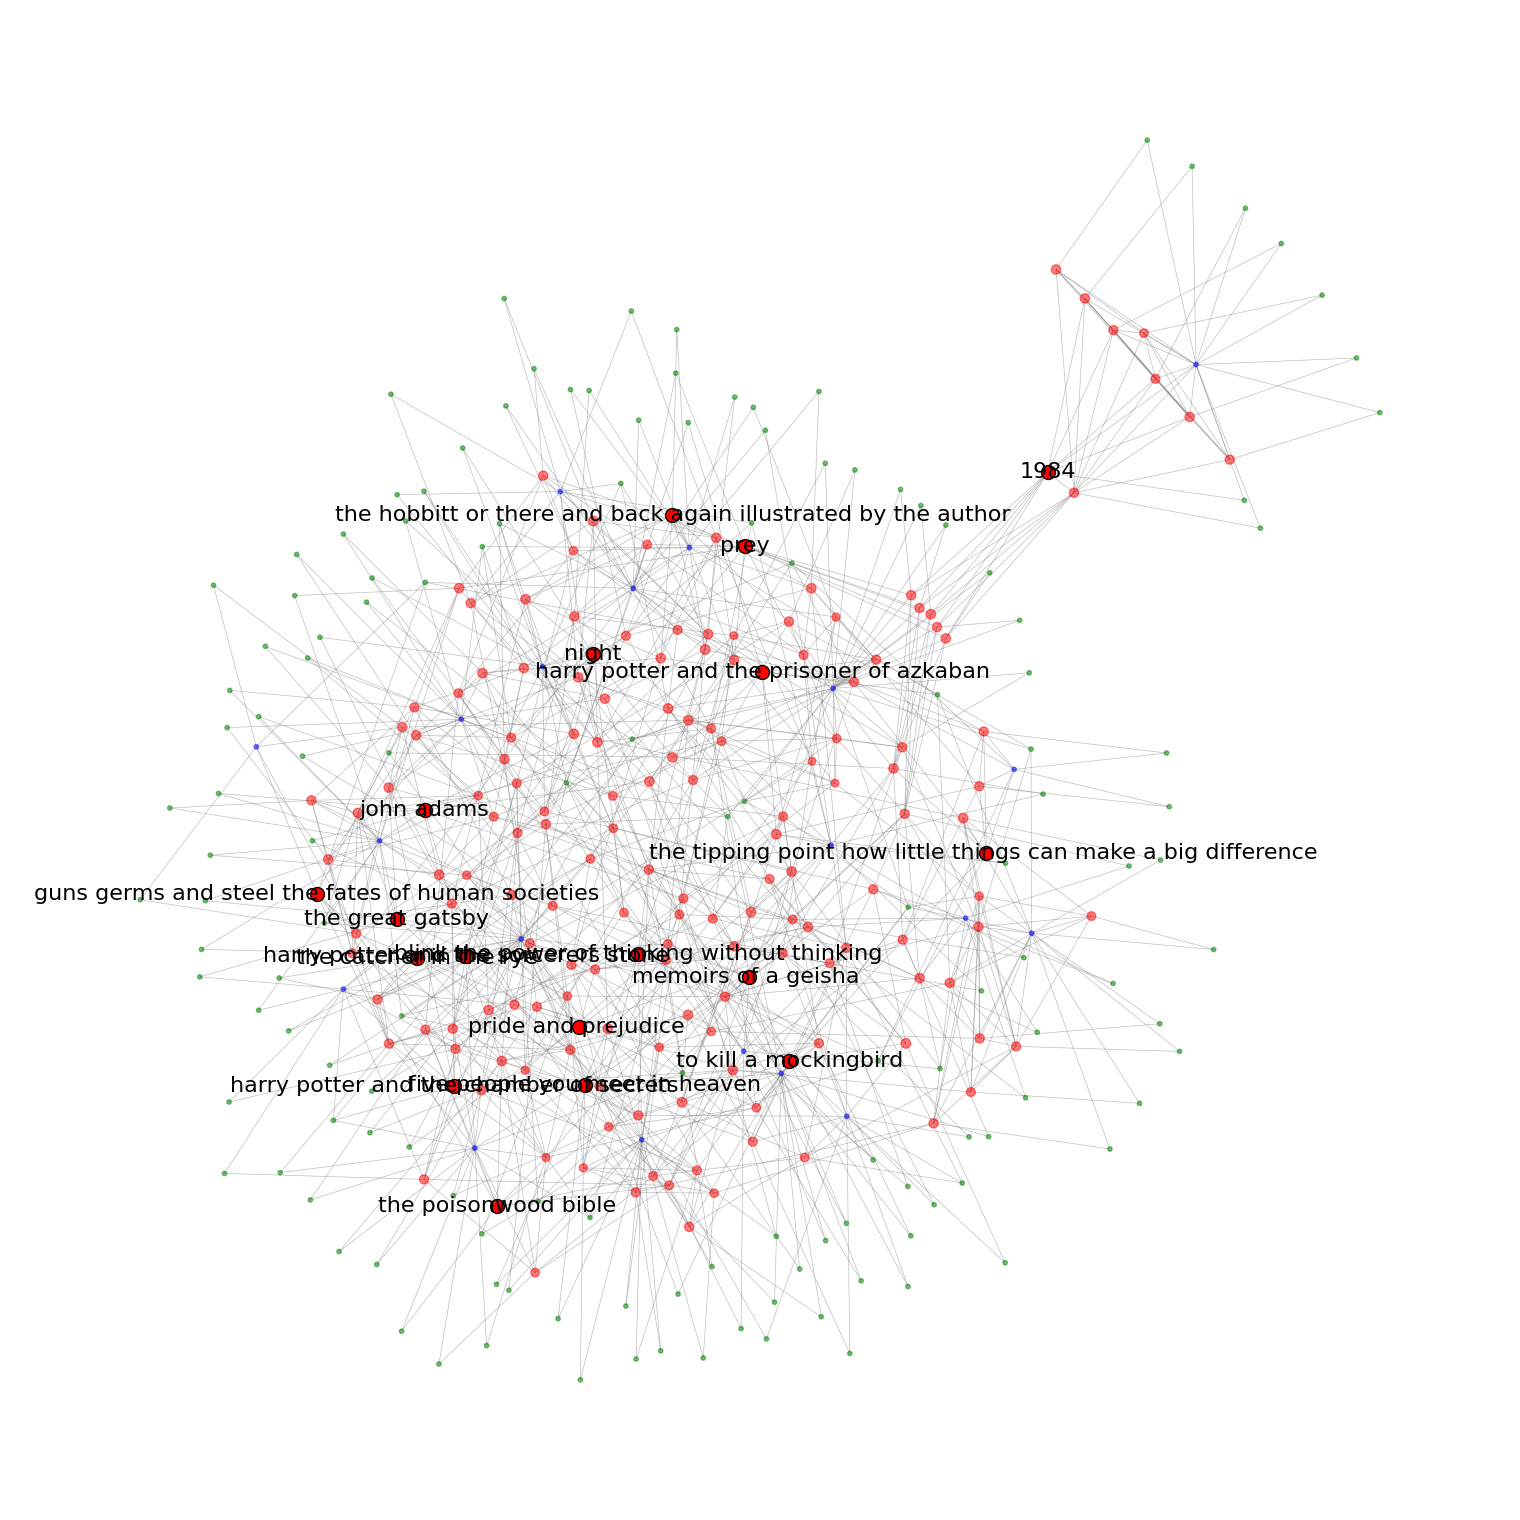

In [94]:
# draw the graph
plt.figure(figsize=(15,15))

# use the kamada_kawai_layout to get the nodes positions
pos = nx.kamada_kawai_layout(G)

# draw the nodes and the edges
nx.draw(G,pos =pos, node_size= sizes, node_color = colors, with_labels=False, alpha=0.5, width=0.5, edge_color='grey')
nx.draw_networkx_labels(G,pos,labels=label_vec,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=label_vec.keys(),node_size=100,node_color='red', edgecolors='black')

# save the graph
plt.savefig('figs/graph.pdf')
plt.show()

In [95]:
# define Adaic-Adar function
def adamic_adar_weight(neighbor_list):
    weight = 0.0
    for neighbor in neighbor_list:
        weight += 1 / math.log(G.degree(neighbor))
    return weight

In [96]:
def get_recommendation(root):
    # Dictionary to store common neighbors and their occurrences
    commons_dict = {}

    # Iterate over neighbors of the root node
    for e in G.neighbors(root):
        # Iterate over neighbors of each neighbor of the root
        for e2 in G.neighbors(e):
            # Skip if the neighbor is the root node
            if e2 == root:
                continue
            
            # Check if the neighbor is a book
            if G.nodes[e2]['label'] == "BOOK":
                commons = commons_dict.get(e2)
                if commons is None:
                    # If the book is not in the dictionary, add it with the current neighbor
                    commons_dict.update({e2: [e]})
                else:
                    # If the book is already in the dictionary, append the current neighbor
                    commons.append(e)
                    commons_dict.update({e2: commons})

    # Lists to store books and their corresponding weights
    books = []
    weight = []

    # Calculate weight for each book based on Adamic-Adar measure
    for key, values in commons_dict.items():
        w = adamic_adar_weight(values)
        books.append(key)
        weight.append(w)

    # Create a pandas Series with book weights and indices
    result = pd.Series(data=np.array(weight), index=books)

    # Sort the Series in descending order based on weights
    result.sort_values(inplace=True, ascending=False)

    return result

In [97]:
# for user obtain the top 5 books based on what he/she has read

# get the books that the test user has read
user_books = popular_books_ratings[popular_books_ratings['user_id'] == test_user][['title','score']]

# remove duplicate titles
user_books.drop_duplicates(subset=['title'], inplace=True)

# extract titles
user_titles = user_books['title'].unique().tolist()

# get the books that the user has not read
user_unread_books = popular_books_data[~popular_books_data['title'].isin(user_titles)]['title'].unique()

# get recommendations for the user
recommendations = pd.DataFrame(columns=["original", 'title', 'score'])
for book in user_titles:
    rec = get_recommendation(book)
    title = rec.index.tolist()
    for t in title:
        if t not in user_unread_books and t not in recommendations['title'].tolist():
            val = rec.values.tolist()
            new_rec = pd.DataFrame({"original": book, 'title': title, 'score': val})
            recommendations = pd.concat([recommendations, new_rec], ignore_index=True)


# sort the recommendations
recommendations.sort_values(by='score',inplace=True,ascending=False)
recommendations.reset_index(drop=True, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14852\1311883342.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendations = pd.concat([recommendations, new_rec], ignore_index=True)


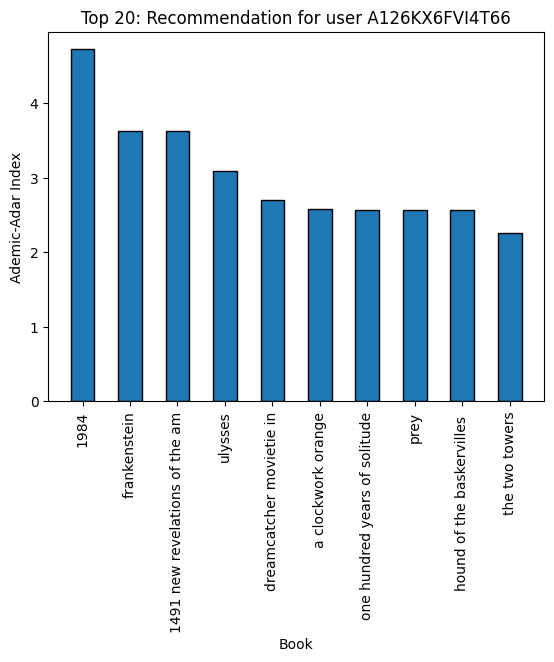

In [98]:
# make plot of the results
plt.figure()
top_20_titles = recommendations["title"][0:10]

# take only first 10 characters of the title
top_20_titles_short = [t[:30] for t in top_20_titles]

top_20_scores = recommendations["score"][0:10]
plt.bar(top_20_titles_short,top_20_scores, edgecolor = "black", width=0.5)
plt.xlabel('Book')
plt.ylabel('Ademic-Adar Index')
plt.title('Top 20: Recommendation for user ' + str(test_user))

plt.xticks(rotation=90)

# set the layout to tight
plt.savefig('figs/recommendation_test_user.pdf', bbox_inches='tight')
plt.show()

In [99]:
# check if the books are in the same cluster
print("Check if the recommended books are in the same cluster")
print(popular_books_data.loc[popular_books_data['title'].isin(top_20_books)]["cluster"].value_counts())

# print the cluster of the books that the user has read
print("Cluster of the books that the user has read")
print(popular_books_data.loc[popular_books_data['title'].isin(user_books["title"])]["cluster"].value_counts())


Check if the recommended books are in the same cluster
cluster
2     2
10    2
7     2
17    2
1     2
5     1
3     1
11    1
15    1
4     1
12    1
6     1
9     1
Name: count, dtype: int64
Cluster of the books that the user has read
cluster
5     1
6     1
0     1
16    1
17    1
14    1
Name: count, dtype: int64


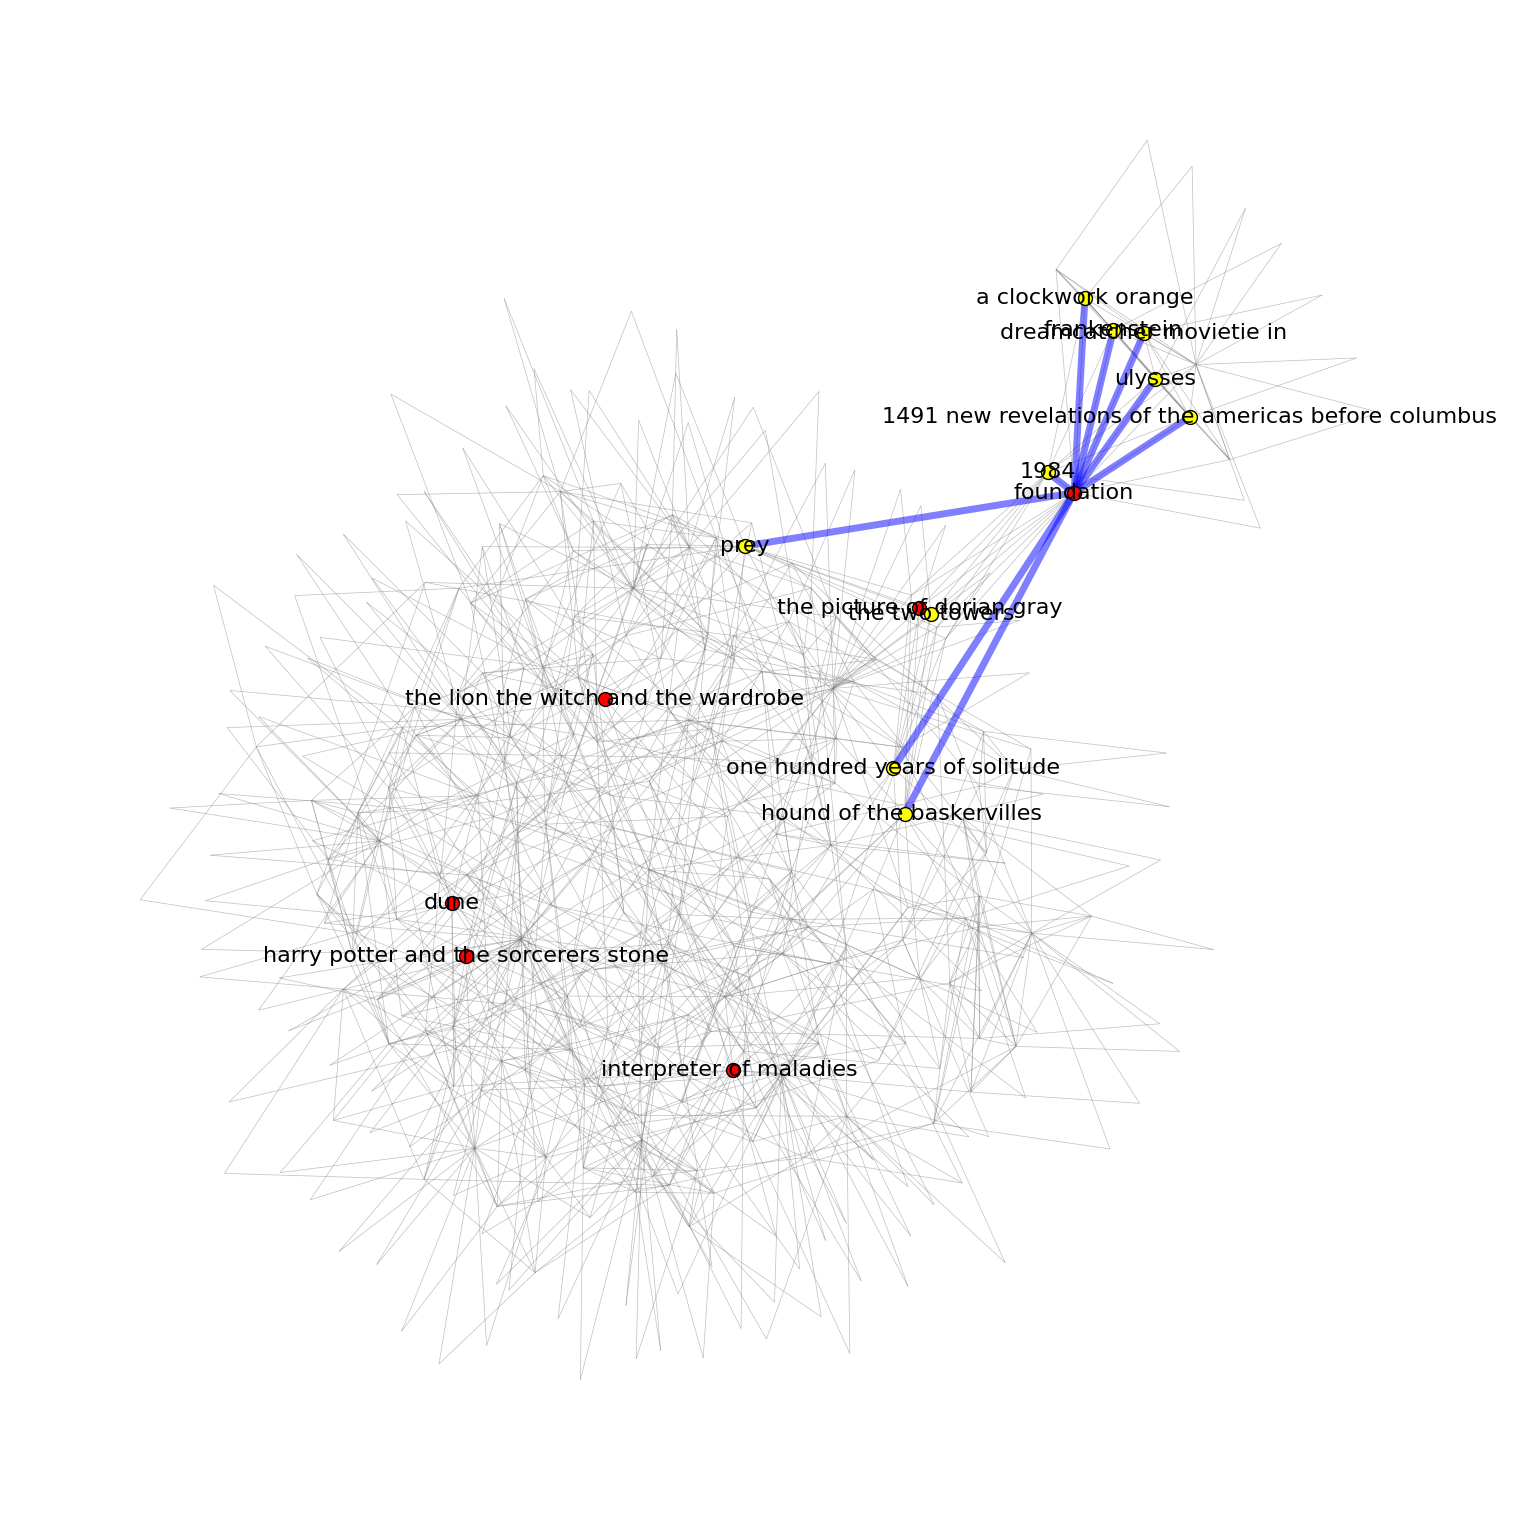

In [100]:
# draw the graph
plt.figure(figsize=(15,15))

# use the kamada_kawai_layout to get the nodes positions
pos = nx.kamada_kawai_layout(G)

# generate a list of colors for the nodes
colors = []
read_books = {}
rec_books = {}
for node in G:
    if G.nodes[node]['label'] == "BOOK":
        if node in top_20_titles.to_list():
            rec_books[node] = node
        if node in user_books["title"].tolist():
            read_books[node] = node

# create edge list based on the recommendations
edge_list = []
for i in range(0,10):
    edge_list.append((recommendations["original"][i], recommendations["title"][i]))
    
# draw the nodes and the edges
nx.draw(G,pos =pos, node_size= sizes, node_color = colors, with_labels=False, alpha=0.5, width=0.5, edge_color='grey')
nx.draw_networkx_labels(G,pos,labels=read_books,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=read_books.keys(),node_size=100,node_color='red', edgecolors='black')
nx.draw_networkx_labels(G,pos,labels=rec_books,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=rec_books.keys(),node_size=100,node_color='yellow', edgecolors='black')
nx.draw_networkx_edges(G,pos,edgelist=edge_list,width=5,alpha=0.5,edge_color='blue')
# save the graph
plt.savefig('figs/graph_results.pdf')
plt.show()